<a href="https://colab.research.google.com/github/AbrahamKong/CMPE297-Graph_Neural_Networks/blob/main/Assignment_2_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Level Prediction using GAT/GCN


## GAT

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

### Obtain the dataset

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

print(citations)

print(papers)

### Split the dataset

In [ ]:
# Obtain random indices
random_indices = np.random.permutation(range(papers.shape[0]))

# 50/50 split
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2 :]]

### Prepare the graph data

In [ ]:
# Obtain paper indices which will be used to gather node states
# from the graph later on when training the model
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()

# Obtain ground truth labels corresponding to each paper_id
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

# Define graph, namely an edge tensor and a node feature tensor
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])

# Print shapes of the graph
print("Edges shape:\t\t", edges.shape)
print("Node features shape:", node_states.shape)

### Build the model

In [ ]:

class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):

        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states
        node_states_transformed = tf.matmul(node_states, self.kernel)

        # (1) Compute pair-wise attention scores
        node_states_expanded = tf.gather(node_states_transformed, edges)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)

        # (2) Normalize attention scores
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out


class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)


#### (Multi-head) graph attention layer

#### Implement training logic with custom `train_step`, `test_step`, and `predict_step` methods

In [ ]:
class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        indices, labels = data

        with tf.GradientTape() as tape:
            # Forward pass
            outputs = self([self.node_states, self.edges])
            # Compute loss
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Compute gradients
        grads = tape.gradient(loss, self.trainable_weights)
        # Apply gradients (update weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        indices = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute probabilities
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        indices, labels = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute loss
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}


### Train and evaluate

In [ ]:
# Define hyper-parameters
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

# Build model
gat_model = GraphAttentionNetwork(
    node_states, edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
)

# Compile model
gat_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

gat_model.fit(
    x=train_indices,
    y=train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping],
    verbose=2,
)

_, test_accuracy = gat_model.evaluate(x=test_indices, y=test_labels, verbose=0)

print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")

### Predict

In [ ]:
test_probs = gat_model.predict(x=test_indices)

mapping = {v: k for (k, v) in class_idx.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

copyright: [akensert](https://github.com/akensert)

## GCN

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

### Loading the CORA network data

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]


In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


### Creating the GCN link model

In [ ]:
epochs = 50

In [ ]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [ ]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [ ]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 121ms/step - loss: 1.8927 - acc: 0.5000
  ['...']
1/1 [==============================] - 0s 9ms/step - loss: 1.8621 - acc: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 1.8927
	acc: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 1.8621
	acc: 0.5000


In [ ]:
#train the model
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

  ['...']
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/50
1/1 - 1s - loss: 1.7886 - acc: 0.5000 - val_loss: 1.5024 - val_acc: 0.5387
Epoch 2/50
1/1 - 0s - loss: 1.7260 - acc: 0.5400 - val_loss: 0.6822 - val_acc: 0.6070
Epoch 3/50
1/1 - 0s - loss: 0.8526 - acc: 0.5953 - val_loss: 0.7401 - val_acc: 0.5729
Epoch 4/50
1/1 - 0s - loss: 0.7397 - acc: 0.5666 - val_loss: 0.7479 - val_acc: 0.5849
Epoch 5/50
1/1 - 0s - loss: 0.7334 - acc: 0.5799 - val_loss: 0.6777 - val_acc: 0.6172
Epoch 6/50
1/1 - 0s - loss: 0.6413 - acc: 0.6404 - val_loss: 0.6981 - val_acc: 0.6375
Epoch 7/50
1/1 - 0s - loss: 0.7289 - acc: 0.6568 - val_loss: 0.6576 - val_acc: 0.6448
Epoch 8/50
1/1 - 0s - loss: 0.6367 - acc: 0.6568 - val_loss: 0.6846 - val_acc: 0.6338
Epoch 9/50
1/1 - 0s - loss: 0.6111 - acc: 0.6639 - val_loss: 0.6850 - val_acc: 0.6384
Epoch 10/50
1/1 - 0s - loss: 0.5818 - acc: 0.6855 - val_loss: 0.6667 - val_acc: 0.6513
Epoch 11/50
1/1 - 0s - loss: 0.5721 - acc: 0.6916 - val_loss: 0.6304 - val_acc:

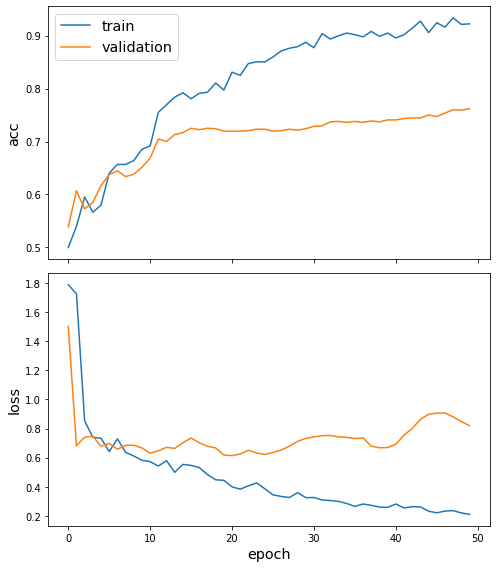

In [ ]:
sg.utils.plot_history(history)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 9ms/step - loss: 0.1409 - acc: 0.9641
  ['...']
1/1 [==============================] - 0s 9ms/step - loss: 0.8198 - acc: 0.7620

Train Set Metrics of the trained model:
	loss: 0.1409
	acc: 0.9641

Test Set Metrics of the trained model:
	loss: 0.8198
	acc: 0.7620


# Node Classification using GAT/GCN

## GAT

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the CORA network

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

In [ ]:
set(node_subjects)

### Splitting the data

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
from collections import Counter

Counter(train_subjects)

Counter({'Rule_Learning': 9,
         'Neural_Networks': 42,
         'Case_Based': 16,
         'Probabilistic_Methods': 22,
         'Genetic_Algorithms': 22,
         'Reinforcement_Learning': 11,
         'Theory': 18})

### Converting to numeric arrays

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

### Creating the GAT model in Keras

In [ ]:
generator = FullBatchNodeGenerator(G, method="gat")

In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [ ]:
x_inp, predictions = gat.in_out_tensors()

### Training the model

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [ ]:
# Train the model
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 0s - loss: 2.0089 - acc: 0.1286 - val_loss: 1.8361 - val_acc: 0.3440
Epoch 2/50
1/1 - 0s - loss: 1.8543 - acc: 0.2786 - val_loss: 1.7295 - val_acc: 0.3860
Epoch 3/50
1/1 - 0s - loss: 1.7033 - acc: 0.4143 - val_loss: 1.6395 - val_acc: 0.3880
Epoch 4/50
1/1 - 0s - loss: 1.5959 - acc: 0.4500 - val_loss: 1.5602 - val_acc: 0.3960
Epoch 5/50
1/1 - 0s - loss: 1.4899 - acc: 0.4786 - val_loss: 1.4882 - val_acc: 0.4360
Epoch 6/50
1/1 - 0s - loss: 1.4368 - acc: 0.5286 - val_loss: 1.4199 - val_acc: 0.5040
Epoch 7/50
1/1 - 0s - loss: 1.3643 - acc: 0.4786 - val_loss: 1.3548 - val_acc: 0.5840
Epoch 8/50
1/1 - 0s - loss: 1.1994 - acc: 0.6286 - val_loss: 1.2938 - val_acc: 0.6420
Epoch 9/50
1/1 - 0s - loss: 1.2092 - acc: 0.6357 - val_loss: 1.2381 - val_acc: 0.6880
Epoch 10/50
1/1 - 0s - loss: 1.1780 - acc: 0.6214 - val_loss: 1.1883 - val_acc: 0.7460
Epoch 11/50
1/1 - 0s - loss: 1.0629 - acc: 0.7571 - val_loss: 1.1438 - val_acc: 0.7540
Epoch 12/50
1/1 - 0s - loss: 0.9646 - acc: 0.7786 - 

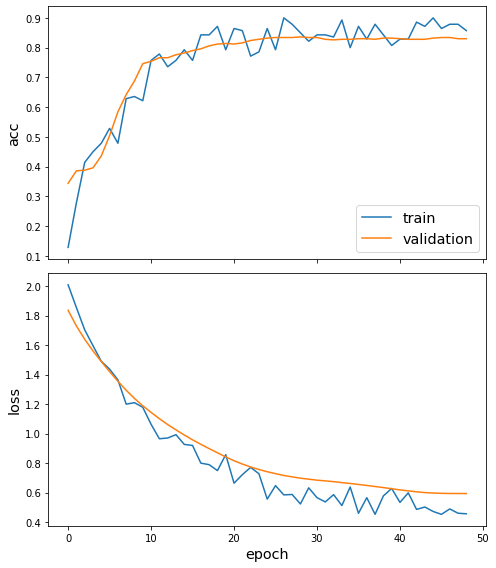

In [ ]:
# Plot the training histroy
sg.utils.plot_history(history)

In [ ]:
model.load_weights("logs/best_model.h5")

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.7227
	acc: 0.8109


### Making predictions with the model

In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


### Node embeddings

In [ ]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse, output shape (1, 2708, 64)


In [ ]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

In [ ]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 64)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [ ]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

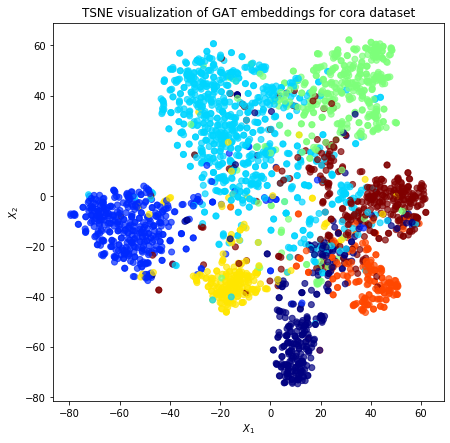

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for cora dataset".format(transform.__name__)
)
plt.show()

## GCN

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preparation



#### Loading the CORA network

In [ ]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]


In [ ]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


#### Splitting the data

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


#### Converting to numeric arrays

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

### 2. Creating the GCN layers

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices/Identity:0' shape=(1, None, 16) dtype=float32>

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### 3. Training and evaluating

#### Training the model

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

  ['...']
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/200
1/1 - 1s - loss: 1.9505 - acc: 0.1000 - val_loss: 1.9182 - val_acc: 0.2820
Epoch 2/200
1/1 - 0s - loss: 1.9004 - acc: 0.3143 - val_loss: 1.8831 - val_acc: 0.3560
Epoch 3/200
1/1 - 0s - loss: 1.8493 - acc: 0.3571 - val_loss: 1.8297 - val_acc: 0.3940
Epoch 4/200
1/1 - 0s - loss: 1.7679 - acc: 0.4500 - val_loss: 1.7643 - val_acc: 0.3700
Epoch 5/200
1/1 - 0s - loss: 1.6747 - acc: 0.4500 - val_loss: 1.7046 - val_acc: 0.3580
Epoch 6/200
1/1 - 0s - loss: 1.5794 - acc: 0.4643 - val_loss: 1.6489 - val_acc: 0.3780
Epoch 7/200
1/1 - 0s - loss: 1.5086 - acc: 0.4714 - val_loss: 1.5843 - val_acc: 0.4440
Epoch 8/200
1/1 - 0s - loss: 1.4128 - acc: 0.5071 - val_loss: 1.5189 - val_acc: 0.5180
Epoch 9/200
1/1 - 0s - loss: 1.2905 - acc: 0.5929 - val_loss: 1.4558 - val_acc: 0.5900
Epoch 10/200
1/1 - 0s - loss: 1.1587 - acc: 0.6714 - val_loss: 1.3988 - val_acc: 0.6320
Epoch 11/200
1/1 - 0s - loss: 1.1166 - acc: 0.7143 - val_loss: 1.3416

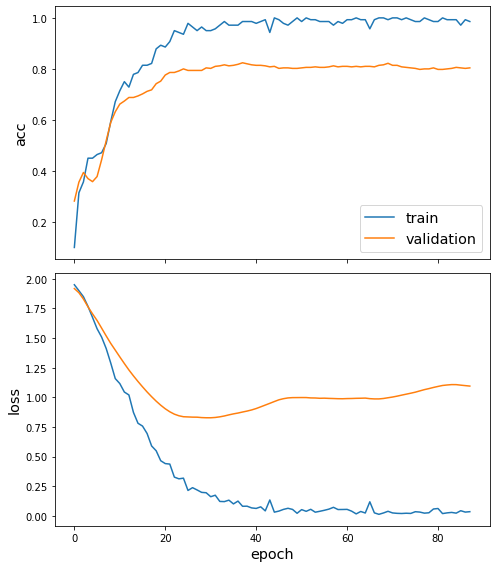

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 11ms/step - loss: 0.6904 - acc: 0.8298

Test Set Metrics:
	loss: 0.6904
	acc: 0.8298


#### Making predictions with the model

In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


#### Node embeddings

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [ ]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [ ]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

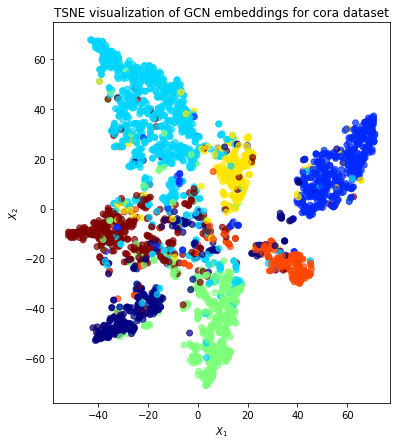

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

# Link  Prediction of Graph

In [ ]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 2.0 MB/s 
     |████████████████████████████████| 2.1 MB 5.2 MB/s 


In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

## GAE for Link Prediction

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [ ]:
# load the Cora dataset
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

In [ ]:
# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

## Simple autoencoder model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [ ]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [ ]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

In [ ]:
z = model.encode()
final_edge_index = model.decode_all(z)

# Reference

1. [Tutorial12 GAE for link prediction.ipynb](https://colab.sandbox.google.com/github/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial12/Tutorial12%20GAE%20for%20link%20prediction.ipynb)
2.[Link Prediction with Graph Neural Networks and
Knowledge Extraction](http://cs230.stanford.edu/projects_spring_2020/reports/38854344.pdf)
3. [COLAB NOTEBOOKS AND VIDEO TUTORIALS](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)
4. [GNN Project #3.1 - Graph-level predictions](https://www.youtube.com/watch?v=CJ-KdKCeiYg&ab_channel=DeepFindr)
5. [Graph Convolutional Networks (GCNs) made simple](https://www.youtube.com/watch?v=2KRAOZIULzw&ab_channel=AlexFoo)
6. [Node classification with Graph ATtention Network (GAT)](https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/gat-node-classification.ipynb)
7. [Node classification with Graph Convolutional Network (GCN)](https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/gcn-node-classification.ipynb)
8. [Link prediction with GCN](https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/gcn-link-prediction.ipynb)
9. [Graph attention network (GAT) for node classification](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/graph/ipynb/gat_node_classification.ipynb#scrollTo=sfDVs2IugNkj)